## 1. Standard Imports

In [1]:
# For Data Visualization
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# to read an image from a url
from imageio import imread

# for number-crunching
import numpy as np

In [3]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## 2. Import the Data

In [4]:
mnist= pd.read_csv("Mnist_combined.csv", index_col=0)

In [5]:
mnist.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Changing to numpy

In [6]:
data = mnist.to_numpy()

In [7]:
data

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [8]:
# We don't need the labels here
X = data[:,1:]

# Normalize the data to a range of [-1 1] (b/c tanh output)
dataNorm = X / np.max(X)   # [0,1] range
dataNorm = 2*dataNorm - 1  # [-1,1] range

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

### GOAL OF THE NETWORK

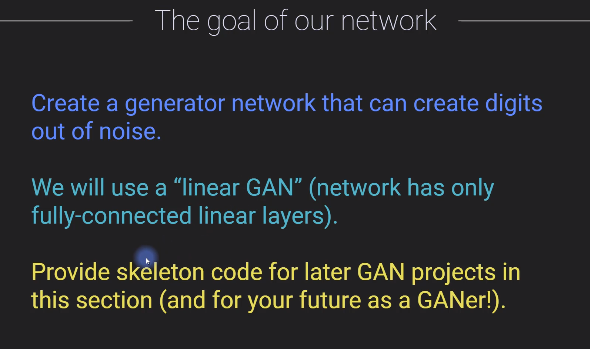

###  MODEL ARCHITECTURE

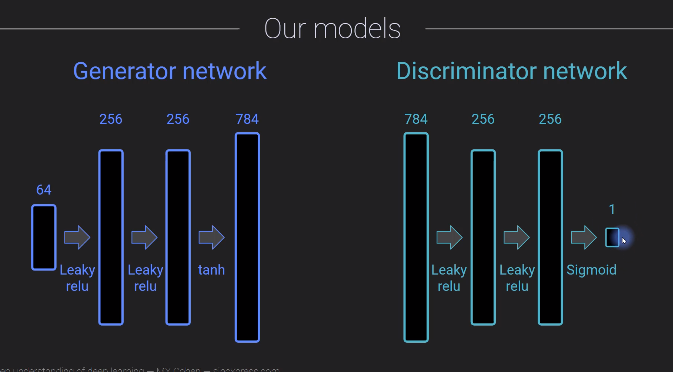

In [9]:
# Generator output : 784 --> 28*28 pixel image output
# Discriminator output : 1 --> True or False (Fake or Real)

## 3. Create Custom classes

### (i) Discriminator class

In [10]:
class discriminatorNet(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(28*28,256)
        self.fc2 = nn.Linear(256,256)
        self.out = nn.Linear(256,1)

    def forward(self,x):
        
        x = F.leaky_relu( self.fc1(x) )
        x = F.leaky_relu( self.fc2(x) )
        x = self.out(x)
        
        return torch.sigmoid( x )



#### Testing

In [11]:
dnet = discriminatorNet()
y = dnet(torch.randn(10,784))
y

tensor([[0.4669],
        [0.5054],
        [0.4953],
        [0.4754],
        [0.4838],
        [0.4590],
        [0.5050],
        [0.4761],
        [0.4977],
        [0.4853]], grad_fn=<SigmoidBackward0>)

### (ii) Generator class

In [12]:
class generatorNet(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(64,256)
        self.fc2 = nn.Linear(256,256)
        self.out = nn.Linear(256,784)

    def forward(self,x):
        
        x = F.leaky_relu( self.fc1(x) )
        x = F.leaky_relu( self.fc2(x) )
        x = self.out(x)
        
        return torch.tanh( x )

#### Testing

In [13]:
gnet = generatorNet()
y = gnet(torch.randn(10,64))

In [14]:
y.shape

torch.Size([10, 784])

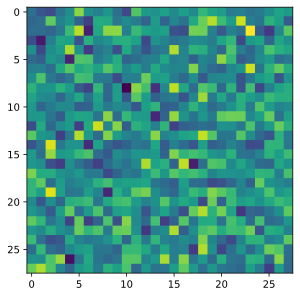

In [15]:
# Extracting the first row
plt.imshow( y[0,:].detach().squeeze().view(28,28) );

## 4. Train the models

### (i) Loss Function , model instances and Optimizers

In [35]:
# loss function (same for both phases of training)
lossfun = nn.BCELoss()

# create instances of the models
dnet = discriminatorNet()
gnet = generatorNet()

# optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

### (ii) Model Training 

In [36]:
# this cell takes 40mins
num_epochs = 50000
batchsize = 100

# shape : (num_epochs, d_loss, g_loss)
losses  = np.zeros((num_epochs,2))

# disDecs = discriminator decisions
disDecs = np.zeros((num_epochs,2)) 


for epochi in range(num_epochs):
    
    # create minibatches of REAL and FAKE images 
    randidx     = torch.randint(low=0, high= dataT.shape[0], size= (batchsize,))
    
    real_images = dataT[randidx,:]
    fake_images = gnet( torch.randn(batchsize,64) ) # output of generator


    # labels used for real and fake images (binary classification 0 & 1)
    real_labels = torch.ones(batchsize,1)
    fake_labels = torch.zeros(batchsize,1)
    
    
    ### ---------------- Train the discriminator ---------------- ###

    # forward pass and loss for REAL pictures
    d_pred_real   = dnet(real_images)              # REAL images into discriminator
    d_loss_real = lossfun(d_pred_real,real_labels) # all labels are 1

    # forward pass and loss for FAKE pictures
    d_pred_fake   = dnet(fake_images)              # FAKE images into discriminator
    d_loss_fake = lossfun(d_pred_fake,fake_labels) # all labels are 0

    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake
    losses[epochi,0]  = d_loss.item()
    
    disDecs[epochi,0] = torch.mean( (d_pred_real>.5).float() ).detach()

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    
    
    ### ---------------- Train the generator ---------------- ###

    # create fake images and compute loss
    fake_images = gnet( torch.randn(batchsize,64) )
    d_pred_fake   = dnet(fake_images)

    # compute and collect loss and accuracy
    g_loss = lossfun(d_pred_fake, real_labels)
    losses[epochi,1]  = g_loss.item()
    
    disDecs[epochi,1] = torch.mean( (d_pred_fake>.5).float() ).detach()

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()
    
    print(f"Running iterations : {epochi}/{num_epochs-1}",end='\r', flush=True)

### Visualization

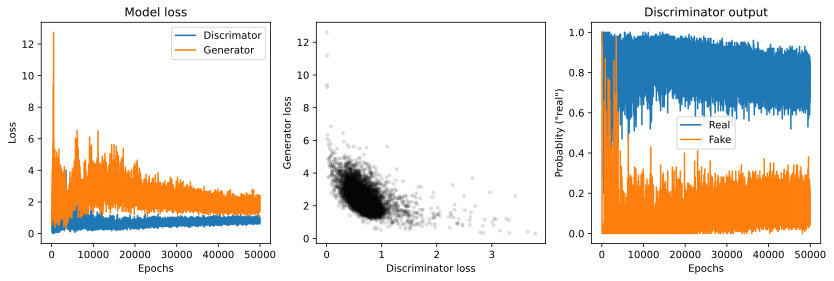

In [39]:
fig,ax = plt.subplots(1,3,figsize=(14,4), dpi=135)

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,5000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(disDecs)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

## Lets see some fake digits

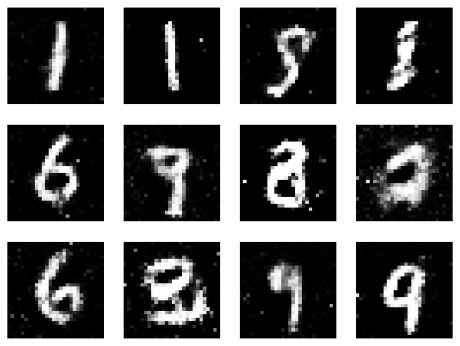

In [40]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(12,64) )

# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6), dpi=135)

for i,ax in enumerate(axs.flatten()):
    
    ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
    ax.axis('off')

plt.show()